In [3]:
from utils import *
import numpy as np
from dataset import DTADataset
dataset = 'davis'

In [2]:
clr_df = pd.read_csv('./data/davis_test.csv')
clr_df.head()

,compound_iso_smiles,target_sequence,target_key,affinity
0,COc1cc(Nc2c(C#N)cnc3cc(OCCCN4CCN(C)CC4)c(OC)cc...,MELRVLLCWASLAAALEETLLNTKLETADLKWVTFPQVDGQWEELS...,EPHB4,8.036212
1,CC(C)(C)c1cc(NC(=O)Nc2ccc(-c3cn4c(n3)sc3cc(OCC...,MEPAAGFLSPRPFQRAAAAPAPPAGPGPPPSALRGPELEMLAGLPT...,PLK3,5.000000
2,COc1cc2c(N3CCN(C(=O)Nc4ccc(OC(C)C)cc4)CC3)ncnc...,MQYLNIKEDCNAMAFCAKMRSSKKTEVNLEAPEPGVEVIFYLSDRE...,JAK1(JH2domain-pseudokinase),5.000000
3,COc1cc2c(Nc3ccc(Br)cc3F)ncnc2cc1OCC1CCN(C)CC1,MISADCNLCLPEYDRYLASSKIMAAAYLDPNLNHTPNSSTKTHLGT...,FAK,5.000000
4,CCN(CC)CCNC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccc(F)c...,MSVGCPEPEPPRSLTCCGPGTAPGPGAGVPLLTEDMQALTLRTLAA...,SBK1,6.698970


In [4]:
# TODO - refer to dataset.py def get_test
msa_path = 'data/' + dataset + '/aln'
contac_path = 'data/' + dataset + '/pconsc4'

test_drugs, test_prot_keys, test_Y, test_pro = list(clr_df['compound_iso_smiles']), list(
    clr_df['target_key']), list(clr_df['affinity']), list(clr_df['target_sequence'])

test_drugs, test_prot_keys, test_Y = np.asarray(test_drugs), np.asarray(test_prot_keys), np.asarray(test_Y)
compound_iso_smiles = set(test_drugs)
target_key = set(test_prot_keys)

proteins = {}
for i in range(clr_df.shape[0]):
    proteins[test_prot_keys[i]] = test_pro[i]
smile_graph = {}
for smile in compound_iso_smiles:
    g = smile_to_graph(smile)
    if g is None:
        continue
    smile_graph[smile] = g

target_graph = {}
for key in target_key:
    if not valid_target(key, dataset):  # ensure the contact and aln files exists
        continue
    g = target_to_graph(key, proteins[key], contac_path, msa_path)
    target_graph[key] = g

# count the number of  proteins with aln and contact files
print('effective drugs,effective prot:', len(smile_graph), len(target_graph))
if len(smile_graph) == 0 or len(target_graph) == 0:
    raise Exception('no protein or drug, run the script for datasets preparation.')

test_dataset = DTADataset(root='data', dataset=dataset, xd=test_drugs, target_key=test_prot_keys,
                            y=test_Y, smile_graph=smile_graph, target_graph=target_graph)

effective drugs,effective prot: 68 442


In [5]:
from torch_geometric.loader import DataLoader

testloader = DataLoader(test_dataset, batch_size=1, shuffle=False,collate_fn=collate)

In [6]:
from lamp_model import *

pid2llm = np.load(f'../{dataset}.npz',allow_pickle=True)['dict'][()]
def testing(model, device, loader):
    model.eval()
    total_preds = torch.Tensor()
    print('Make prediction for {} samples...'.format(len(loader.dataset)))
    with torch.no_grad():
        for data in loader:
            data_mol = data[0].to(device)
            data_pro = data[1].to(device)
            data_llm = pids_to_llm(data[2], pid2llm, device)
            output = model(data_mol, data_pro, data_llm)
            total_preds = torch.cat((total_preds, output.cpu()), 0)
    return total_preds.numpy().flatten()

gpu = 2
model = LAMPCM()
load_model_path = '/data5/luozc/projects/DTA/GINCM-DTA/save/20221213_232033_davis/model/epoch-1266, loss-0.1977, test_loss-0.2150.pt'
save_model = torch.load(load_model_path)
model_dict = model.state_dict()
state_dict = {k:v for k,v in save_model.items() if k in model_dict.keys()}
model_dict.update(state_dict)
model.load_state_dict(model_dict)

GINNet Loaded


<All keys matched successfully>

In [7]:
device = torch.device(f'cuda:{gpu}' if torch.cuda.is_available() else 'cpu')
model.to(device)
print('-----Testing-----')
clr_df['affinity_pred'] = testing(model, device,testloader)

-----Testing-----
Make prediction for 5009 samples...


In [12]:
model_path = load_model_path.replace('/', '_')
csv_dir = f'./output/{dataset}/'
!mkdir -p {csv_dir}
clr_df.to_csv(csv_dir + model_path[: model_path.rfind('.')] + '.csv', index=False)

In [13]:
Y = clr_df['affinity']
P = clr_df['affinity_pred']

get_mse(Y, P), get_cindex(Y, P), get_rm2(Y, P), get_pearson(Y, P), get_spearman(Y, P)

(0.5388417282835505,
 0.8860169004236605,
 0.8860169004236605,
 0.21498659999260303,
 0.8647975183472287,
 0.694349519034859,
 0.6954959143621586)

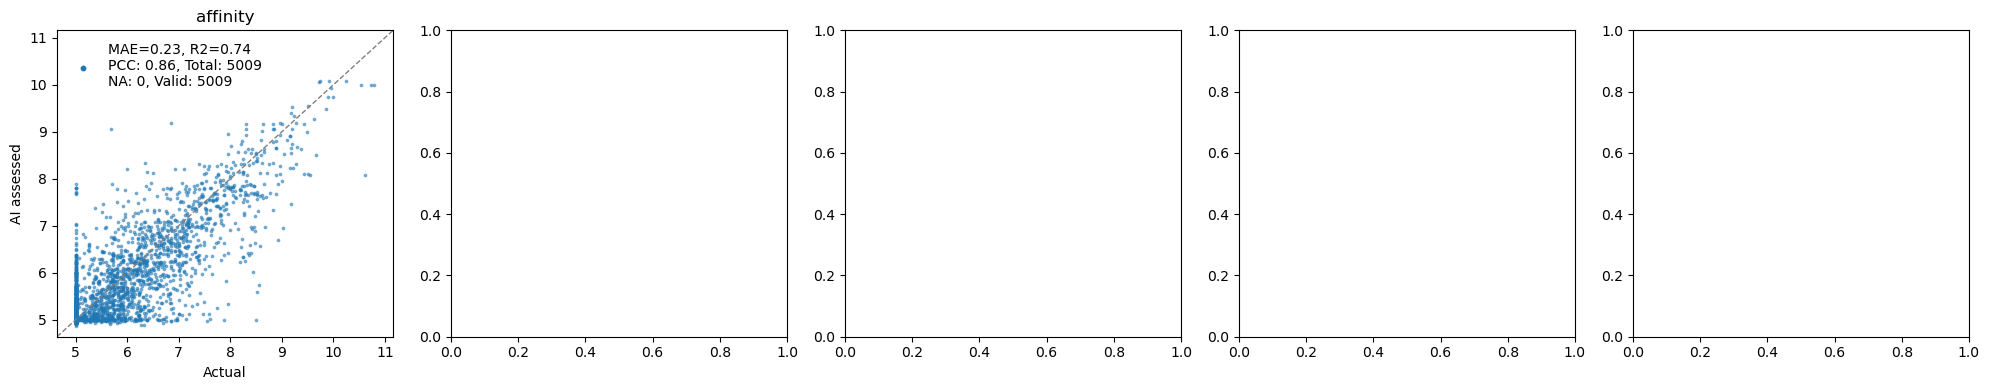

In [1]:
from vis_utils import reg_plot_for_one_label
import pandas as pd
clr_df = pd.read_csv('/data5/luozc/projects/DTA/GINCM-DTA/output/davis/_data5_luozc_projects_DTA_GINCM-DTA_save_20221213_232033_davis_model_epoch-1266, loss-0.1977, test_loss-0.2150.csv')
reg_plot_for_one_label(clr_df, 'affinity')